In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import compute_tilt_data, tilt_distance_LI

# with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
#     dic_eddies_vert = pickle.load(f)

# df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

# df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")

# df_eddies = df_eddies.merge(
#     df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
#     how='left',
#     left_on=['Eddy', 'Day'],
#     right_on=['Eddy', 'Day']
# )
# df_eddies


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


,Eddy,Day,TiltDis,TiltDir,TD
0,0,3,107.700239,284.692395,112.725013
1,0,4,108.636827,284.407336,115.435930
2,0,5,109.767127,284.338205,111.205270
3,0,6,109.959398,284.288499,115.970424
4,0,7,110.896293,284.565582,116.033074
5,0,8,111.104355,284.560614,115.969394
6,0,9,112.121655,284.339475,111.590250
7,0,10,111.659383,284.075755,118.253059
8,0,11,111.092949,284.517331,118.701543
9,0,12,110.750468,284.313399,114.357007


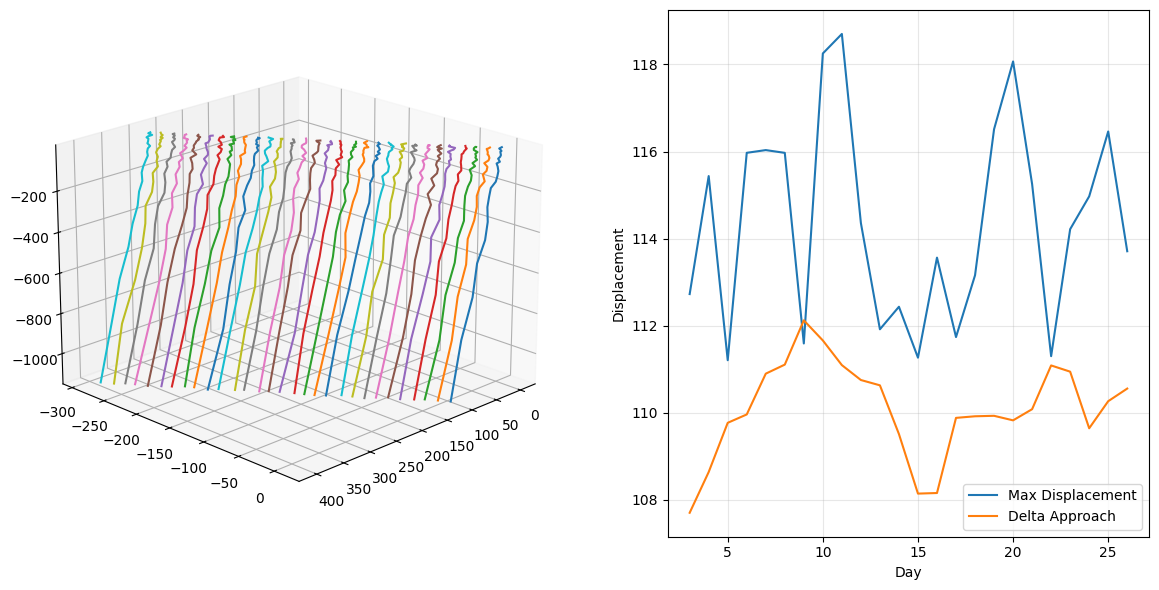

In [3]:
z = -z_r[150,150,:23]
x, y = .1*z, .01*z
df_base = pd.DataFrame({'x': x, 'y': y, 'Depth': z_r[150,150,:23]})

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2, width_ratios=[1.3, 1])

ax3d = fig.add_subplot(gs[0,0], projection='3d')
ax2d = fig.add_subplot(gs[0,1])

dic = {}
TDs = []

for k in range(30):
    df = df_base.copy()

    # main drift
    df['x'] = df['x'] + 10*k
    df['y'] = df['y'] - 10*k
    
    # random wiggle
    df['x'] += np.random.uniform(-3, 3, size=len(df))
    df['y'] += np.random.uniform(-3, 3, size=len(df))

    dic[f'Day{k}'] = df
    ax3d.plot(df.x, df.y, df.Depth)

    # TDs.append(np.hypot(df.x.iloc[0] - df.x.iloc[-1],
    #                     df.y.iloc[0] - df.y.iloc[-1]))
    TD, _, _ = tilt_distance_LI(df.x, df.y, df.Depth)
    TDs.append(TD)

ax3d.view_init(elev=20, azim=45)

df_tilt_data = compute_tilt_data(dic, 0, max_depth=max(np.abs(z)))
df_tilt_data['TD'] = TDs[3:-3]

# ---- right subplot ----
ax2d.plot(df_tilt_data.Day, df_tilt_data.TD, label='Max Displacement')
ax2d.plot(df_tilt_data.Day, df_tilt_data.TiltDis, label='Delta Approach')

ax2d.set_xlabel('Day')
ax2d.set_ylabel('Displacement')
ax2d.legend()
ax2d.grid(alpha=0.3)

plt.tight_layout()

df_tilt_data


,Eddy,Day,TiltDis,TiltDir,TD
0,0,3,118.755879,289.159526,167.675073
1,0,4,107.360257,282.541094,181.106037
2,0,5,93.229302,285.411306,77.340326
3,0,6,112.077926,289.187958,62.102686
4,0,7,107.895166,283.950173,55.729944
5,0,8,108.913960,287.812456,183.870156
6,0,9,115.726742,286.714264,203.383607
7,0,10,82.344897,293.846699,146.541137
8,0,11,72.731912,307.436443,177.456050
9,0,12,60.106593,292.261920,131.208437


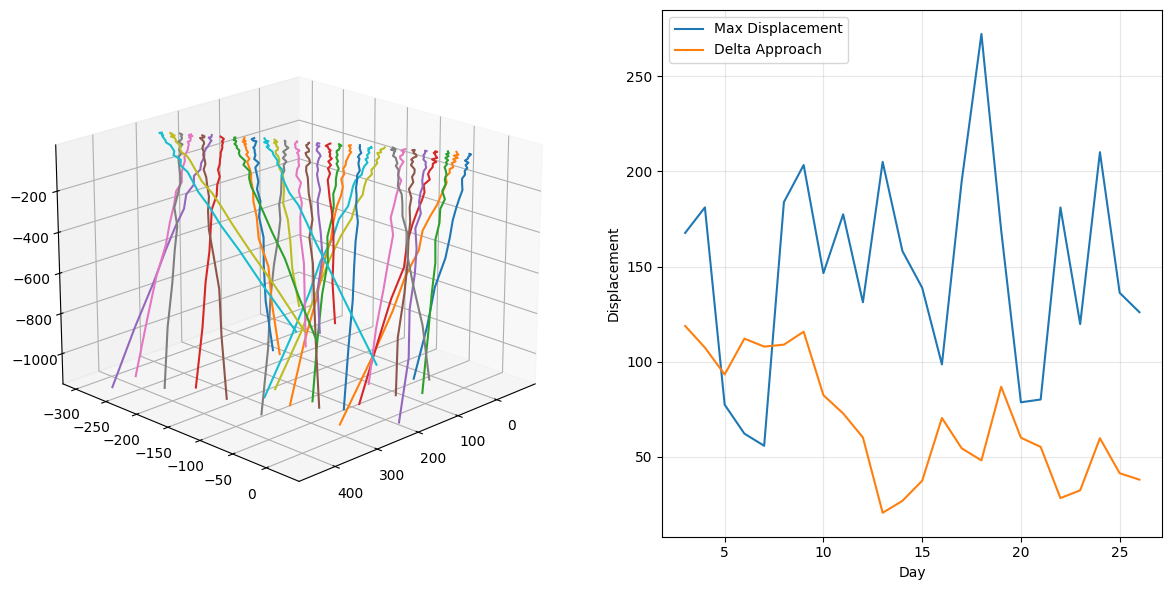

In [4]:
z = -z_r[150,150,:23]
base_depth = z_r[150,150,:23]
df_base = pd.DataFrame({'Depth': base_depth})

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])  # wider left for 3D

ax3d = fig.add_subplot(gs[0,0], projection='3d')
ax2d = fig.add_subplot(gs[0,1])

dic = {}
TDs = []

for k in range(30):
    df = df_base.copy()

    # --- dramatic tilt change per day ---
    sx = 0.1 * np.random.uniform(0.3, 2.5) * np.sign(np.random.randn())
    sy = 0.01 * np.random.uniform(0.3, 2.5) * np.sign(np.random.randn())

    # base tilt
    x_tilt = sx * z
    y_tilt = sy * z

    # random rotation
    angle = np.deg2rad(np.random.uniform(-40, 40))
    xr = x_tilt*np.cos(angle) - y_tilt*np.sin(angle)
    yr = x_tilt*np.sin(angle) + y_tilt*np.cos(angle)

    df['x'] = xr
    df['y'] = yr

    # drift
    df['x'] += 10*k
    df['y'] -= 10*k

    # small wiggle
    df['x'] += np.random.uniform(-3, 3, size=len(df))
    df['y'] += np.random.uniform(-3, 3, size=len(df))

    dic[f'Day{k}'] = df
    ax3d.plot(df.x, df.y, df.Depth)

    # TDs.append(np.hypot(df.x.iloc[0] - df.x.iloc[-1],
    #                     df.y.iloc[0] - df.y.iloc[-1]))

    TD, _, _ = tilt_distance_LI(df.x, df.y, df.Depth)
    TDs.append(TD)

ax3d.view_init(elev=20, azim=45)

df_tilt_data = compute_tilt_data(dic, 0, max_depth=max(np.abs(z)))
df_tilt_data['TD'] = TDs[3:-3]

# --- right panel ---
ax2d.plot(df_tilt_data.Day, df_tilt_data.TD, label='Max Displacement')
ax2d.plot(df_tilt_data.Day, df_tilt_data.TiltDis, label='Delta Approach')

ax2d.set_xlabel('Day')
ax2d.set_ylabel('Displacement')
ax2d.legend()
ax2d.grid(alpha=0.3)

plt.tight_layout()

df_tilt_data


,Eddy,Day,TiltDis,TiltDir,TD
0,0,3,93.546415,260.763668,104.556558
1,0,4,69.498363,255.895626,57.462882
2,0,5,47.836235,250.273834,64.421017
3,0,6,28.601786,242.245351,50.867058
4,0,7,19.387187,241.971847,31.048593
5,0,8,23.056795,246.671804,41.709423
6,0,9,25.724599,249.305195,8.524538
7,0,10,33.795784,254.140045,40.276120
8,0,11,49.582061,261.409633,80.354537
9,0,12,76.904255,266.706797,80.347973


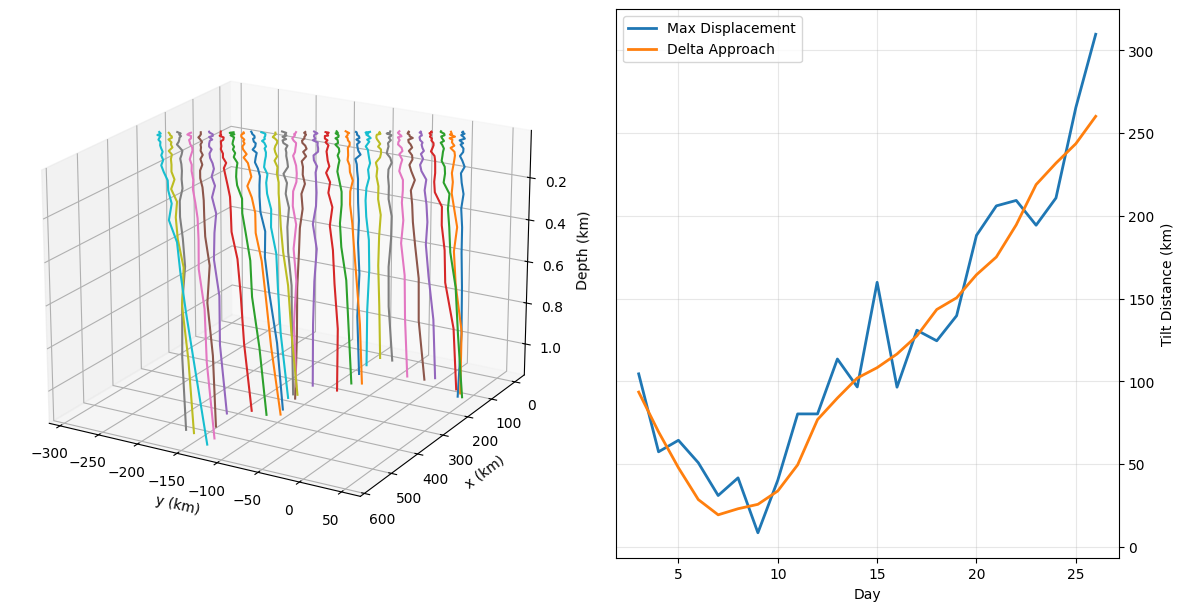

In [103]:
z = -z_r[150,150,:23]
base_depth = z_r[150,150,:23]
df_base = pd.DataFrame({'Depth': base_depth})

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1], wspace=0.05)  # bigger left panel

ax3d = fig.add_subplot(gs[0,0], projection='3d')
ax2d = fig.add_subplot(gs[0,1])

dic = {}
TDs = []

# initial tilt and angle
sx = 0.1
sy = 0.01
angle = 0.0

for k in range(30):
    df = df_base.copy()

    # --- evolving tilt ---
    sx += 0.3 * 0.1  * np.random.randn()
    sy += 0.3 * 0.01 * np.random.randn()
    angle += np.deg2rad(np.random.randn() * 5)

    sx = np.clip(sx, -0.3, 0.3)
    sy = np.clip(sy, -0.05, 0.05)
    angle = np.clip(angle, np.deg2rad(-60), np.deg2rad(60))

    x_tilt = sx * z
    y_tilt = sy * z

    xr = x_tilt*np.cos(angle) - y_tilt*np.sin(angle)
    yr = x_tilt*np.sin(angle) + y_tilt*np.cos(angle)

    df['x'] = xr
    df['y'] = yr

    df['x'] += 10*k
    df['y'] -= 10*k

    df['x'] += np.random.uniform(-3, 3, size=len(df))
    df['y'] += np.random.uniform(-3, 3, size=len(df))

    dic[f'Day{k}'] = df
    ax3d.plot(df.x, df.y, -df.Depth/1e3)
    
    # TDs.append(np.hypot(df.x.iloc[0] - df.x.iloc[-1],
    #                     df.y.iloc[0] - df.y.iloc[-1]))
    TD, _, _ = tilt_distance_LI(df.x, df.y, df.Depth)
    TDs.append(TD)

ax3d.set_xlabel('x (km)'); ax3d.set_ylabel('y (km)'); 
ax3d.set_zlabel('Depth (km)'); 
ax3d.view_init(elev=20, azim=30)

ax3d.zaxis.set_ticks_position('upper')
ax3d.zaxis.set_label_position('upper')
ax3d.invert_zaxis()

df_tilt_data = compute_tilt_data(dic, 0, max_depth=max(np.abs(z)))
df_tilt_data['TD'] = TDs[3:-3]

# --- right panel ---
ax2d.plot(df_tilt_data.Day, df_tilt_data.TD, label='Max-Displacement', lw=2)
ax2d.plot(df_tilt_data.Day, df_tilt_data.TiltDis, label='Delta', lw=2)
ax2d.set_xlabel('Day')
ax2d.set_ylabel('Tilt Distance (km)')
ax2d.legend()
ax2d.grid(alpha=0.3)

ax2d.yaxis.tick_right()
ax2d.yaxis.set_label_position("right")

df_tilt_data
